## Data Collection Procedures for the 2020 N-SSATS
### Field period and reference date
### The survey reference date for the 2020 N-SSATS was March 31, 2020. The field period was from March 31, 2020, through December 14, 2020.
## Survey universe
### The 2020 N-SSATS facility universe totaled 19,926 facilities, including all 18,434 active treatment facilities on SAMHSA’s I-BHS at a point five weeks before the survey reference date, and 1,492facilities that were added by state substance abuse agencies or otherwise discovered during the data collection period.

In [55]:
# Dependencies and Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts

### Import opioid mortality rate dataset

In [65]:
health04_S_file_path = "../Resources/Health04/Health04_S.csv"
mortality_data = pd.read_csv(health04_S_file_path)
mortality_df = pd.DataFrame(mortality_data)
mortality_df.head(3)

,G_STATEFP,STATEFP,st_abb,st_name,opPrscRt19,prMisuse19,odMortRt14,odMortRt15,odMortRt16,odMortRt17,odMortRt18,odMortRt19,odMortRtAv
0,G01,1,AL,Alabama,39.1,4.55,15.2,15.7,16.2,18.0,16.6,16.3,16.33
1,G02,2,AK,Alaska,85.8,3.99,16.8,16.0,16.8,20.2,14.6,17.8,17.03
2,G04,4,AZ,Arizona,80.9,3.80,18.2,19.0,20.3,22.2,23.8,26.8,21.72


### Before getting carried away, create a dataframe with state abbreviation and opioid mortality rate from mortality_data

In [86]:
mort_df = mortality_df.loc[:,['st_abb', 'odMortRtAv']]
mort_df = mort_df.rename(columns={'st_abb' : 'STATE', 'odMortRtAv' : 'odMortRtAv'})
mort_df.head(5)

,STATE,odMortRtAv
0,AL,16.33
1,AK,17.03
2,AZ,21.72
3,AR,14.18
4,CA,12.18


### Import treatment facility dataset

In [87]:
nssats_file_path = "../Resources/NSSATS/NSSATS_PUF_2020_CSV.csv"

facility_data = pd.read_csv(nssats_file_path, low_memory=False)
facility_data.head(3)

,CASEID,STATE,STFIPS,DETOX,TREATMT,SMISEDSUD,OWNERSHP,FEDOWN,HOSPITAL,LOCS,...,T_CLIHI_X,T_CLIML_D,T_CLIML_O,T_CLIML_X,T_CLIOP_D,T_CLIOP_O,T_CLIOP_X,T_CLIRC_D,T_CLIRC_O,T_CLIRC_X
0,1,AK,2,0,1,1,6,3.0,0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN
1,2,AK,2,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,3,AK,2,1,1,0,2,NaN,0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [88]:
facility_df = pd.DataFrame(data)
facility_df.shape

(16066, 264)

### Remove Jurisdictions not included in Health04 dataset

In [90]:
fac_df = facility_df.loc[facility_df.STATE != 'PR'].loc[facility_df.STATE != 'ZZ']
fac_df.STATE.nunique()

51

### Merge mortality and facility dfs

In [91]:
pd.merge(fac_df, mort_df, on = "STATE", how = "inner") 

,CASEID,STATE,STFIPS,DETOX,TREATMT,SMISEDSUD,OWNERSHP,FEDOWN,HOSPITAL,LOCS,...,T_CLIML_X,T_CLIOP_D,T_CLIOP_O,T_CLIOP_X,T_CLIRC_D,T_CLIRC_O,T_CLIRC_X,TFQ,TFQ_BIN,odMortRtAv
0,1,AK,2,0,1,1,6,3.0,0,NaN,...,1.0,NaN,NaN,4.0,NaN,NaN,NaN,29.0,C,17.03
1,2,AK,2,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,39.5,A,17.03
2,3,AK,2,1,1,0,2,NaN,0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,30.0,B,17.03
3,4,AK,2,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,34.5,B,17.03
4,5,AK,2,1,1,0,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.5,A,17.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15950,16052,WY,56,0,1,1,2,NaN,0,NaN,...,1.0,NaN,NaN,4.0,NaN,NaN,NaN,25.5,C,15.13
15951,16053,WY,56,1,1,1,2,NaN,0,NaN,...,4.0,NaN,NaN,5.0,NaN,NaN,4.0,36.0,A,15.13
15952,16054,WY,56,0,1,1,2,NaN,0,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,33.0,B,15.13
15953,16055,WY,56,0,1,1,2,NaN,0,NaN,...,1.0,NaN,NaN,3.0,NaN,NaN,NaN,28.0,C,15.13


### TFQ Analysis starts here:

In [38]:
a = df.ASSESSMENT #(0-8)
b = df.TESTING #(0-9)
c = df.TRANSITION #(0-4)
d = df.RECOVERY #(0-6)
e = df.EDUCATION #(0-10)
f = df.PHARMACOTHERAPIES #(0-16)

In [39]:
df['TFQ'] = (a)+(b)+(2*c)+(1.5*d)+(e)+(.5*f)
tfq = df.TFQ
tfq

0        29.0
1        39.5
2        30.0
3        34.5
4        43.5
         ... 
16051    25.5
16052    36.0
16053    33.0
16054    28.0
16055    30.0
Name: TFQ, Length: 15955, dtype: float64

<AxesSubplot:ylabel='Frequency'>

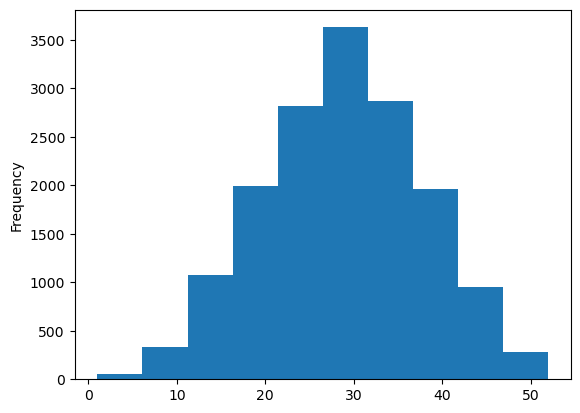

In [40]:
tfq.plot.hist()

In [32]:
tfq.describe()

count    16066.000000
mean        28.748724
std          9.020898
min          1.000000
25%         22.500000
50%         29.000000
75%         35.500000
max         52.000000
Name: TFQ, dtype: float64

In [53]:
tfq_bins = [0, 22, 29, 35.5, 52]
tfq_bin_names = ["D", "C", "B", "A"]

df['TFQ_BIN'] = pd.cut(df['TFQ'], tfq_bins, labels=tfq_bin_names, include_lowest=True)
df.TFQ_BIN.value_counts()

C    4179
B    4063
D    3976
A    3737
Name: TFQ_BIN, dtype: int64

### Aggregate by State (later on)

<AxesSubplot:ylabel='Frequency'>

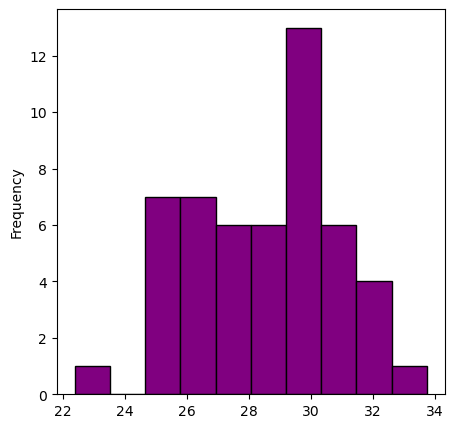

In [51]:
tfq_groupby_df = df.groupby('STATE')['TFQ'].mean()
tfq_groupby_df.plot.hist(figsize=[5,5],color='purple',edgecolor='black')

<AxesSubplot:ylabel='Frequency'>

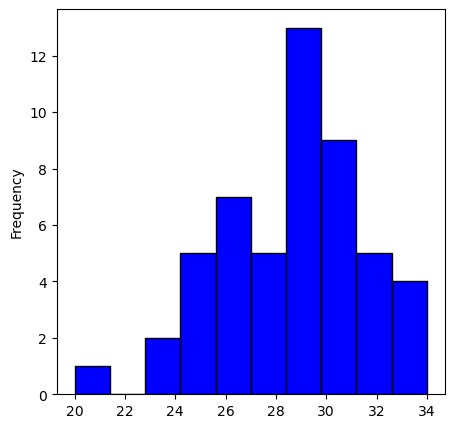

In [50]:
tfq_groupby_df = df.groupby('STATE')['TFQ'].median()
tfq_groupby_df.plot.hist(figsize=[5,5],color='blue',edgecolor='black')

In [ ]:
### Using the median yields a more normal distribution

### Initial EDA Guiding Question: Why is the opioid mortality rate so high in WV?

In [5]:
WV = df.loc[df.STATE == 'WV']
WV.head(5)

,CASEID,STATE,STFIPS,DETOX,TREATMT,SMISEDSUD,OWNERSHP,FEDOWN,HOSPITAL,LOCS,...,T_CLIHI_X,T_CLIML_D,T_CLIML_O,T_CLIML_X,T_CLIOP_D,T_CLIOP_O,T_CLIOP_X,T_CLIRC_D,T_CLIRC_O,T_CLIRC_X
15870,15871,WV,54,0,1,1,2,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15871,15872,WV,54,0,1,1,1,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15872,15873,WV,54,1,1,0,1,NaN,0,NaN,...,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
15873,15874,WV,54,1,1,0,1,NaN,0,NaN,...,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
15874,15875,WV,54,1,1,0,1,NaN,0,NaN,...,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN


In [6]:
columns = WV.columns
columns

Index(['CASEID', 'STATE', 'STFIPS', 'DETOX', 'TREATMT', 'SMISEDSUD',
       'OWNERSHP', 'FEDOWN', 'HOSPITAL', 'LOCS',
       ...
       'T_CLIHI_X', 'T_CLIML_D', 'T_CLIML_O', 'T_CLIML_X', 'T_CLIOP_D',
       'T_CLIOP_O', 'T_CLIOP_X', 'T_CLIRC_D', 'T_CLIRC_O', 'T_CLIRC_X'],
      dtype='object', length=262)

In [35]:
n_caseid = WV.CASEID.count()
print(f"There are responses from {n_caseid} West Virginia treatment centers in this dataset.") 

There are responses from 126 West Virginia treatment centers in this dataset.


In [36]:
wv_detox_vc = WV.DETOX.value_counts()
wv_detox_vc

0    86
1    40
Name: DETOX, dtype: int64

In [37]:
print(f"{wv_detox_vc[0]} of 126 treament facilities in WV did not offer detoxification.")
print(f"{wv_detox_vc[1]} of 126 treament facilities in WV offered detoxification.")

86 of 126 treament facilities in WV did not offer detoxification.
40 of 126 treament facilities in WV offered detoxification.


### Discover how to calculate percent offering detoxification

In [38]:
wv_percent_detox = round(wv_detox_vc[1]/(wv_detox_vc[0]+wv_detox_vc[1]),2)
wv_percent_detox

0.32

### Question to Group: Which boolean (0,1) variables would we like to loop through to calculate variables?

### 1.DETOX: Facility offers detoxification
### 2.TREATMT: Facility offers substance use treatment
### 3.SMISEDSUD: Facility offers treatment for co-occurring serious mental illness (SMI)/serious emotional disturbance (SED) and substance use disorders

### Psuedocode: For every variable_name in my list of Y/N (0/1) variables, calculate value_counts and then calculate % facilities offering said variable

In [39]:
important_variables = ['DETOX', 'TREATMT', 'SMISEDSUD']

stats = {}
for variable in important_variables:
    y = WV[variable].value_counts()
    z = round(y[1]/(y[0]+y[1]),2)
    stats[variable] = z
stats

{'DETOX': 0.32, 'TREATMT': 0.99, 'SMISEDSUD': 0.83}

## Note to Group: Loop through the entire dataset to pull a dictionary of these statistics for each Top Ten State

### Note from tutoring:
### - value_counts are set up by pandas...
### - value_counts is a series
### - in a series if you request a key that doesnt exist, pandas will return an error

In [40]:
top_ten_states = ['WV', 'DE', 'NH', 'OH', 'PA', 'KY', 'MD', 'MA', 'ME', 'RI']

important_variables = ['DETOX', 'TREATMT', 'SMISEDSUD']

full_dict = {}
for state in top_ten_states:
    subset = df.loc[df['STATE'] == state]
    stats = {}
    for variable in important_variables:
        y = subset[variable].value_counts()
        try:
            n_false = y[0]
        except:
            n_false = 0
        try:
            n_true = y[1]
        except:
            n_true = 0
        z = round(n_true/(n_false + n_true),2)
        stats[variable] = z
    full_dict[state] = stats
full_dict

{'WV': {'DETOX': 0.32, 'TREATMT': 0.99, 'SMISEDSUD': 0.83},
 'DE': {'DETOX': 0.16, 'TREATMT': 1.0, 'SMISEDSUD': 0.82},
 'NH': {'DETOX': 0.2, 'TREATMT': 1.0, 'SMISEDSUD': 0.46},
 'OH': {'DETOX': 0.29, 'TREATMT': 0.99, 'SMISEDSUD': 0.62},
 'PA': {'DETOX': 0.18, 'TREATMT': 1.0, 'SMISEDSUD': 0.4},
 'KY': {'DETOX': 0.21, 'TREATMT': 1.0, 'SMISEDSUD': 0.7},
 'MD': {'DETOX': 0.24, 'TREATMT': 0.99, 'SMISEDSUD': 0.57},
 'MA': {'DETOX': 0.2, 'TREATMT': 0.99, 'SMISEDSUD': 0.63},
 'ME': {'DETOX': 0.07, 'TREATMT': 0.99, 'SMISEDSUD': 0.67},
 'RI': {'DETOX': 0.37, 'TREATMT': 0.98, 'SMISEDSUD': 0.59}}

In [41]:
stats_df = pd.DataFrame(full_dict)
stats_df

,WV,DE,NH,OH,PA,KY,MD,MA,ME,RI
DETOX,0.32,0.16,0.20,0.29,0.18,0.21,0.24,0.20,0.07,0.37
TREATMT,0.99,1.00,1.00,0.99,1.00,1.00,0.99,0.99,0.99,0.98
SMISEDSUD,0.83,0.82,0.46,0.62,0.40,0.70,0.57,0.63,0.67,0.59


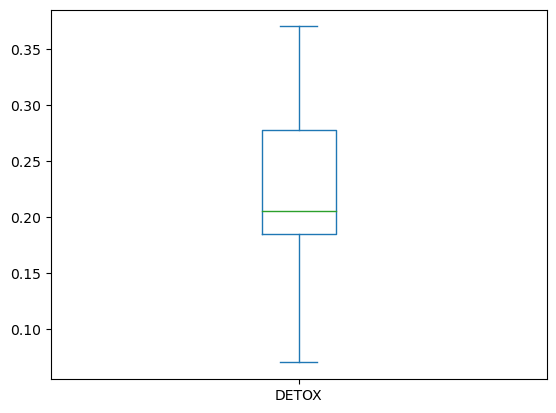

In [42]:
stats_df.iloc[0].plot.box()
plt.show()

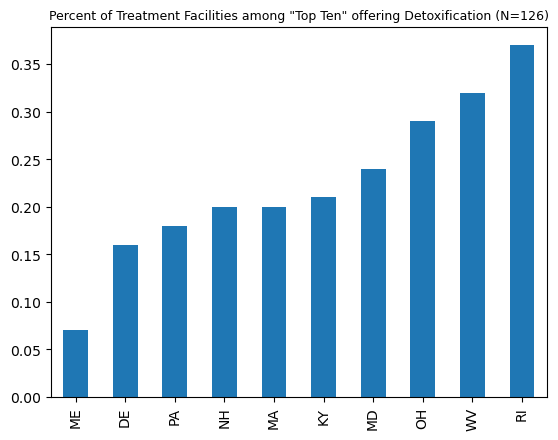

In [51]:
stats_df.iloc[0].sort_values(ascending=True).plot.bar()
plt.title('Percent of Treatment Facilities among "Top Ten" offering Detoxification (N=126)',size=9)
plt.show()

In [44]:
states = list(df['STATE'].unique())

important_variables = ['DETOX', 'TREATMT', 'SMISEDSUD']

full_dict = {}
for state in states:
    subset = df.loc[df['STATE'] == state]
    stats = {}
    for variable in important_variables:
        y = subset[variable].value_counts()
        try:
            n_false = y[0]
        except:
            n_false = 0
        try:
            n_true = y[1]
        except:
            n_true = 0
        z = round(n_true/(n_false + n_true),2)
        stats[variable] = z
    full_dict[state] = stats
full_dict

{'AK': {'DETOX': 0.11, 'TREATMT': 0.99, 'SMISEDSUD': 0.69},
 'AL': {'DETOX': 0.2, 'TREATMT': 0.95, 'SMISEDSUD': 0.48},
 'AR': {'DETOX': 0.15, 'TREATMT': 0.98, 'SMISEDSUD': 0.72},
 'AZ': {'DETOX': 0.23, 'TREATMT': 0.99, 'SMISEDSUD': 0.67},
 'CA': {'DETOX': 0.39, 'TREATMT': 0.99, 'SMISEDSUD': 0.54},
 'CO': {'DETOX': 0.15, 'TREATMT': 0.99, 'SMISEDSUD': 0.64},
 'CT': {'DETOX': 0.18, 'TREATMT': 0.98, 'SMISEDSUD': 0.77},
 'DC': {'DETOX': 0.18, 'TREATMT': 1.0, 'SMISEDSUD': 0.61},
 'DE': {'DETOX': 0.16, 'TREATMT': 1.0, 'SMISEDSUD': 0.82},
 'FL': {'DETOX': 0.27, 'TREATMT': 0.98, 'SMISEDSUD': 0.67},
 'GA': {'DETOX': 0.26, 'TREATMT': 0.99, 'SMISEDSUD': 0.6},
 'HI': {'DETOX': 0.12, 'TREATMT': 1.0, 'SMISEDSUD': 0.25},
 'IA': {'DETOX': 0.12, 'TREATMT': 1.0, 'SMISEDSUD': 0.63},
 'ID': {'DETOX': 0.15, 'TREATMT': 1.0, 'SMISEDSUD': 0.88},
 'IL': {'DETOX': 0.18, 'TREATMT': 0.99, 'SMISEDSUD': 0.54},
 'IN': {'DETOX': 0.23, 'TREATMT': 1.0, 'SMISEDSUD': 0.64},
 'KS': {'DETOX': 0.14, 'TREATMT': 0.98, 'SMISEDS

In [45]:
full_stats_df = pd.DataFrame(full_dict)
full_stats_df

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,ZZ
DETOX,0.11,0.20,0.15,0.23,0.39,0.15,0.18,0.18,0.16,0.27,...,0.21,0.29,0.29,0.23,0.19,0.11,0.17,0.32,0.27,0.7
TREATMT,0.99,0.95,0.98,0.99,0.99,0.99,0.98,1.00,1.00,0.98,...,1.00,1.00,0.98,1.00,0.98,0.99,0.99,0.99,1.00,1.0
SMISEDSUD,0.69,0.48,0.72,0.67,0.54,0.64,0.77,0.61,0.82,0.67,...,0.69,0.53,0.79,0.73,0.67,0.49,0.72,0.83,0.88,0.8


In [46]:
stats_df_drop_ZZ = full_stats_df.drop(columns='ZZ')

<AxesSubplot:>

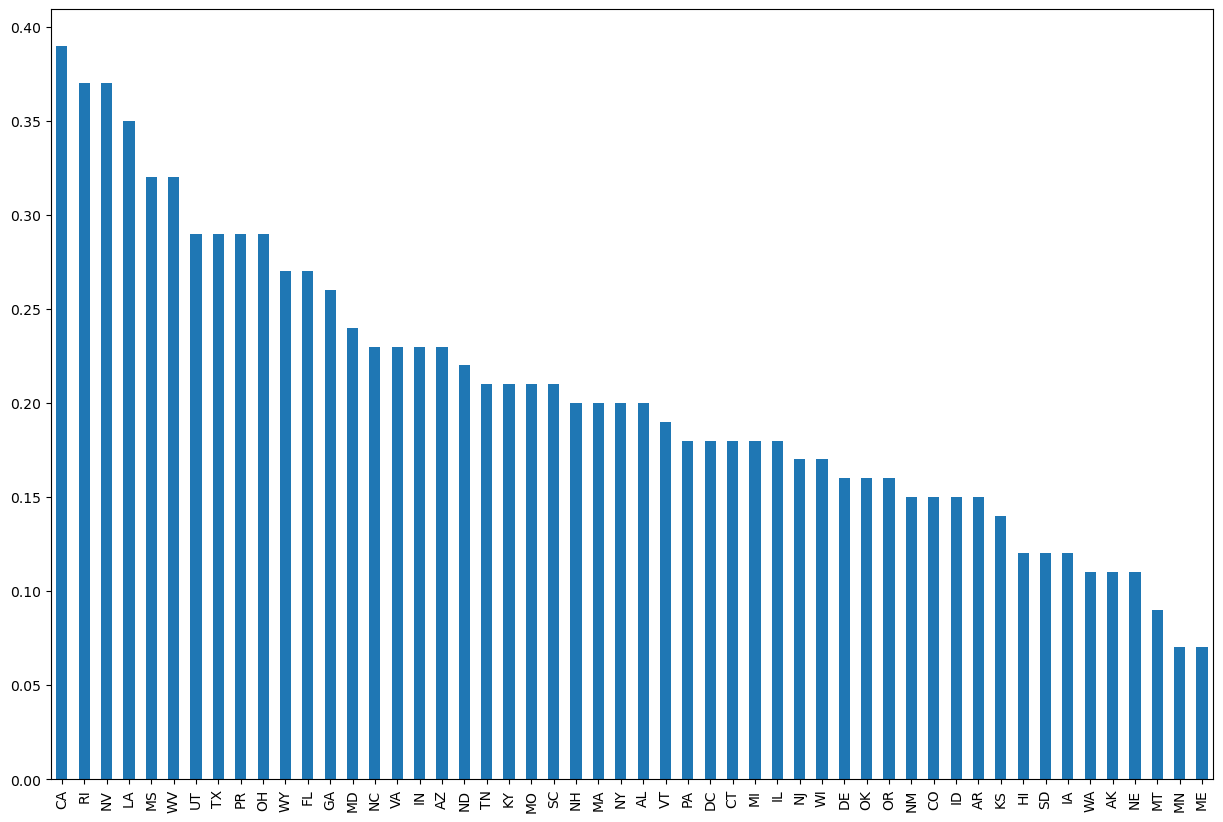

In [47]:
stats_df_drop_ZZ.iloc[0].sort_values(ascending=False).plot.bar(figsize = [15,10])

<AxesSubplot:>

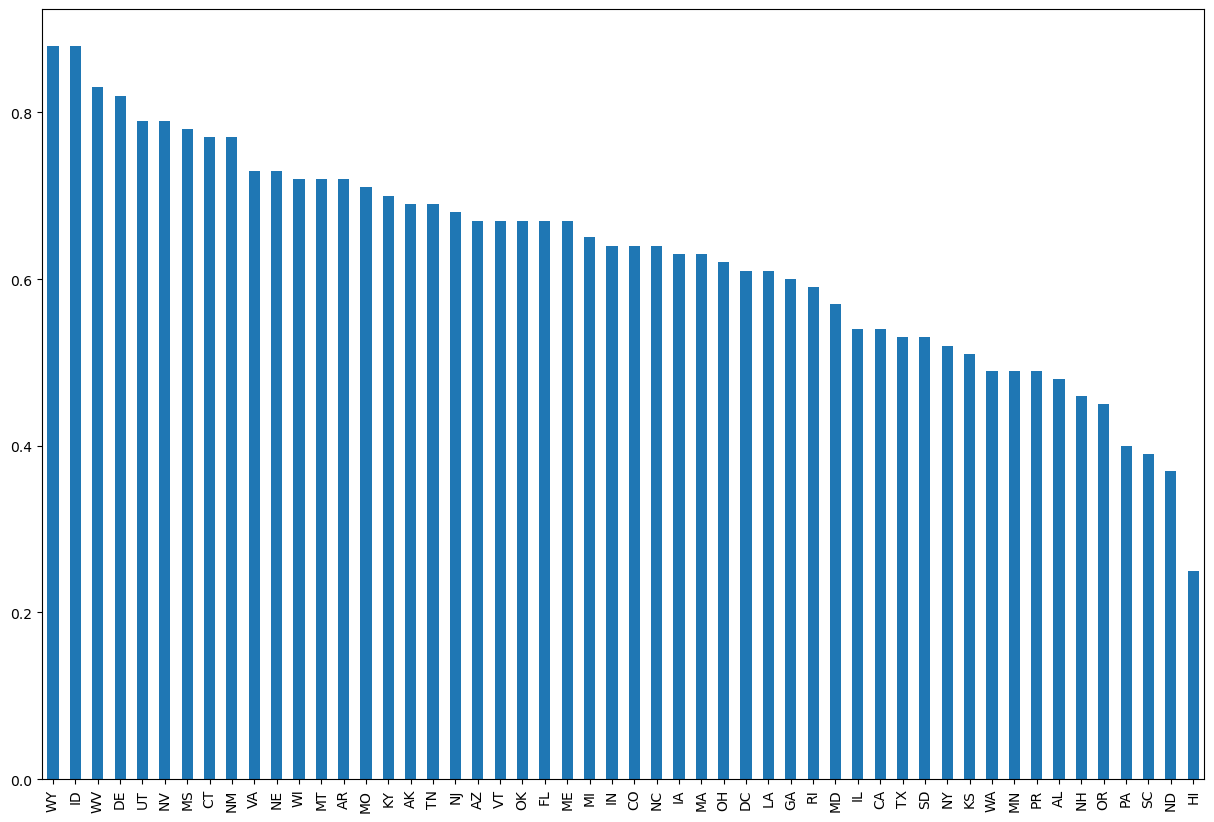

In [48]:
stats_df_drop_ZZ.iloc[2].sort_values(ascending=False).plot.bar(figsize = [15,10])

In [50]:
stats_df_transposed = stats_df_drop_ZZ.T
len(stats_df_transposed)

52

### For later...
### ASSESSMENT: Number of assessment and pre-treatment services offered by this facility (0-8) (pg.31)

In [ ]:
for col in columns:
    print(col)

In [ ]:
df = pd.DataFrame(data)

In [4]:
top_ten_states = ['WV', 'DE', 'NH', 'OH', 'PA', 'KY', 'MD', 'MA', 'ME', 'RI']